In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import sys
sys.path.append("..")

In [6]:
from rom_tools.rom_manager import RomManager

In [8]:
rom_m = RomManager("../../roms/sm_guinea_pig.smc", "../../roms/sm_newlevel.smc")

In [9]:
# 7A788 - Cathedral
# 7ACB3 - Bubble Mountain

# Green Brinstar Elevator
# Beetoms Room (should be one cluster)
# West Ocean?
# Morph Ball Room
# Wrecked Ship main room
# Pre-Spazer
# Green Brinstar Reserve

In [10]:
from rom_tools import graphics

In [11]:
tileset_table = graphics.get_tileset_table(rom_m)
cre_tile_sheet = graphics.get_cre_tilesheet(rom_m)
cre_tile_table = graphics.get_cre_tile_table(rom_m)

In [12]:
objnames = rom_m.parse()

In [13]:
lb = objnames["room_header_0x7acb3"].state_chooser.default.level_data.level_bytes

In [14]:
from world_rando.coord import *

In [15]:
def default(state):
    return state.state_chooser.default

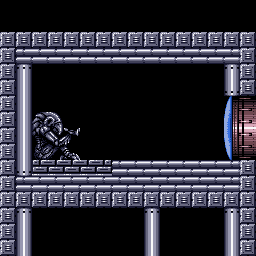

In [16]:
limage = graphics.image_from_state(default(objnames["room_header_0x7a107"]), rom_m)
# Gross PIL stuff
limage2 = limage.convert("RGB")
limage2

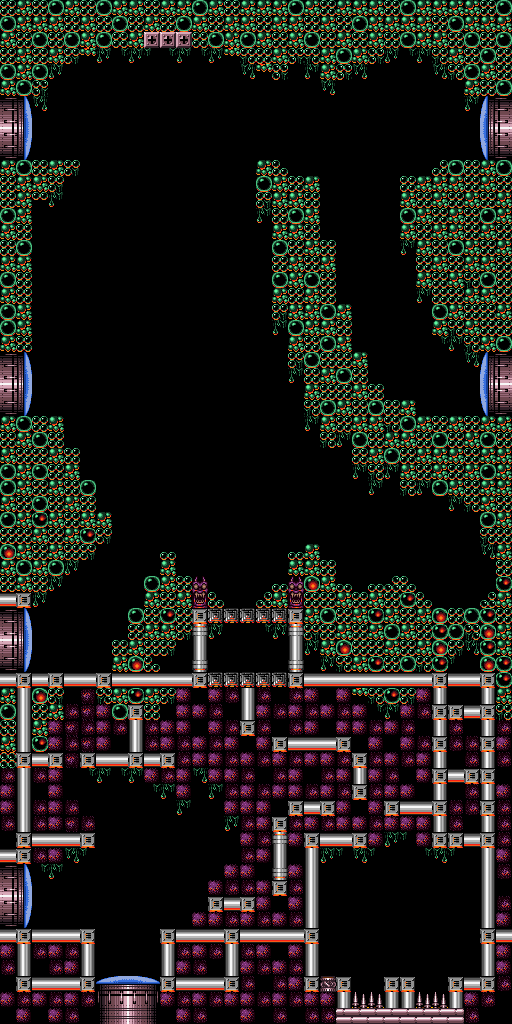

In [17]:
limage = graphics.image_from_state(default(objnames["room_header_0x7acb3"]), rom_m)
# Gross PIL stuff
limage2 = limage.convert("RGB")
limage2

In [18]:
level_array = objnames["room_header_0x7acb3"].state_chooser.default.level_data.level_array.layer1

In [19]:
import numpy as np

In [22]:
from world_rando.isovision import *

In [23]:
is_air = mk_is_air(level_array)

In [89]:
# YAY
#matshow(is_air.T)

In [25]:
#TODO: clustering by "visible region"
# Do raycasting to determine the set of visible points from each location
# Then cluster based on the symmetric set difference
# The visible region for a given cluster is the union of all visible regions for its members
# -- This will break morph tunnels up into small / many clusters with low sampling
# -- But allow correct analysis of Green Hill Zone
# -- What to do about morph regions?
# Thinking of the Room + Corridor example, we have
# [Room] [Room, Corridor] [Corridor]
# Should [Room, Corridor] be a separate cluster?

# -> Cluster based on the /gradient/ of normalized symmetric set differences

In [26]:
2.1 % 1.5

0.6000000000000001

In [50]:
def view_visible(c):
    s = calc_visible(c, is_air, n_iters=300)
    vis = np.zeros_like(is_air)
    for c in iter2d(is_air):
        if c in s:
            vis[c] = 1
    matshow(vis.T)

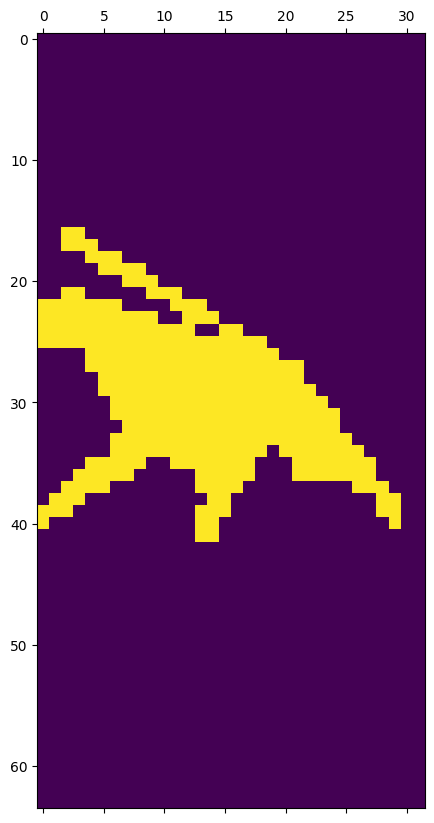

In [90]:
view_visible(Coord(21,27))
#view_visible(Coord(21,28))

In [54]:
visibles = mk_visibles(is_air)

In [61]:
airs = mk_airs(is_air)

(array([171., 153., 312., 323., 253., 187., 130.,  80.,  64.,  50.,  44.,
         28.,  39.,  23.,  17.,  19.,  14.,   8.,  17.,   8.,  12.,  15.,
          7.,   8.,   2.,   8.,   1.,   5.,   2.,   2.,   0.,   0.,   4.,
          1.,   2.,   2.,   0.,   1.,   2.,   0.,   2.,   3.,   1.,   3.,
          2.,   2.,   1.,   0.,   1.,   1.]),
 array([0.        , 0.01794183, 0.03588367, 0.0538255 , 0.07176734,
        0.08970917, 0.10765101, 0.12559284, 0.14353468, 0.16147651,
        0.17941834, 0.19736018, 0.21530201, 0.23324385, 0.25118568,
        0.26912752, 0.28706935, 0.30501119, 0.32295302, 0.34089485,
        0.35883669, 0.37677852, 0.39472036, 0.41266219, 0.43060403,
        0.44854586, 0.4664877 , 0.48442953, 0.50237136, 0.5203132 ,
        0.53825503, 0.55619687, 0.5741387 , 0.59208054, 0.61002237,
        0.62796421, 0.64590604, 0.66384787, 0.68178971, 0.69973154,
        0.71767338, 0.73561521, 0.75355705, 0.77149888, 0.78944072,
        0.80738255, 0.82532438, 0.84326622, 0.

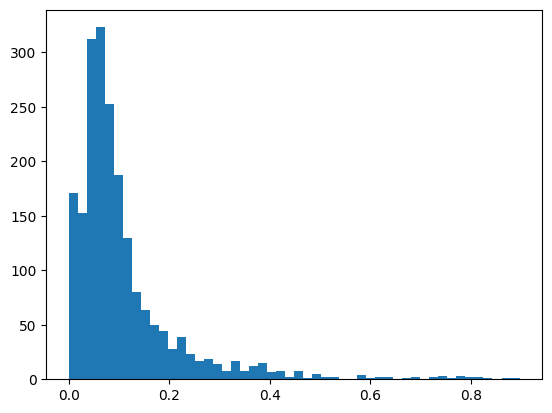

In [62]:
# Plot the distribution of pairwise distances
_, _, pdists = initial_conditions_visible(visibles, mask=airs)
plt.hist(pdists.values(), bins=50)

In [63]:
openness_random = mk_openness(is_air, lambda x, y: calc_openness_raster(x, y, n_iters=300))

In [64]:
#matshow(openness_random.T)

In [65]:
openness_0 = mk_openness(is_air, calc_openness)

In [66]:
#matshow(openness_0.T)

In [67]:
openness_1 = blur(openness_0)

In [68]:
#matshow(openness_1.T)

In [69]:
openness_r1 = blur(openness_random)

In [70]:
#matshow(openness_r1.T)

In [71]:
# Hierarchical Clustering!

In [73]:
_, _, pairwise_dist = initial_conditions_open(openness_r1)

In [75]:
from scipy.stats import ttest_ind

In [76]:
ttest_ind([1, 2], [10, 11], equal_var=False)

TtestResult(statistic=-12.727922061357855, pvalue=0.006116265326381103, df=2.0)

In [78]:
#plt.hist(pairwise_dist.values(), bins=50)
cluster_threshold_distance(openness_r1)

5.981349667245372

In [79]:
cluster_threshold_structure(openness_r1)

3.394194444444445

In [80]:
#clusters, pheap = hierarchical_cluster(ssds_b, 0.0001, mask=airs)
cluster_state = glom(initial_conditions_visible(visibles, mask=airs), 0.29)
cluster_cleanup(cluster_state, 6, randomly=True)

In [84]:
ca = mk_class_array(openness_1, cluster_state, sort=sort_vis)

In [87]:
ca.shape, ca.T.shape
ca[(16, 16)]

21.0

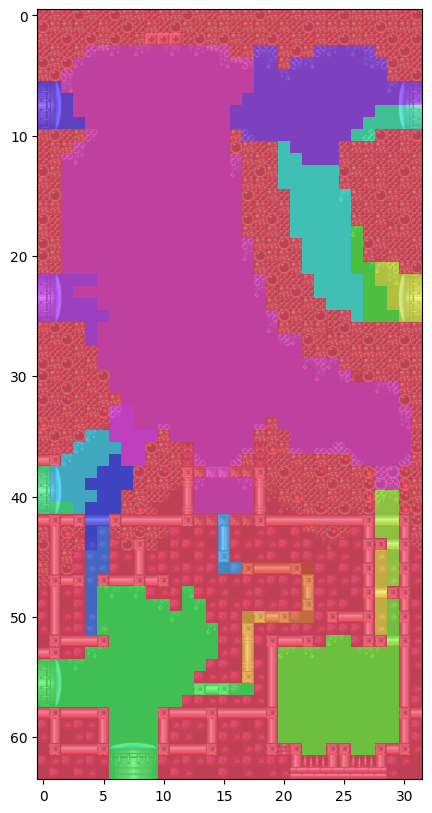

In [81]:
#TODO: allow jumping 2px for cluster adjacency?
#TODO: what if we just get rid of solid tiles?
#TODO: recovering cluster graph from neighbors[...]
#TODO: what about treating up/down vs. left/right separately?
#TODO: -- Or, attach remaining small clusters to the (closest) and (most similar) cluster?
#TODO: more circular openness score?
#TODO: ratio between min and max??
#TODO: gaussian sampling?
#TODO: jump over destructible blocks for initial adjacency
#TODO: place boundaries on the biggest differential of means!
# Determine experimentally if designers place barriers this way
# Neighborhood Clustering:
# Choose the largest number of clusters such that small clusters don't exist?
# Minimize within-variation while maximizing between-variation
# between-variation / total variation
# There's a citation for this
#TODO: treat the breakable blocks as if they're air
# The larger a cluster is, the more likely it is to "accept" adding smaller stuff...
figsize(10,10)
# Why do we need these 0.5s? Thanks matplotlib
plt.imshow(limage2, alpha=0.5, extent=(-0.5, openness_1.shape[0] -0.5, openness_1.shape[1] -0.5, -0.5))
plt.imshow(mk_class_array(openness_1, cluster_state, sort=sort_vis).T, alpha=0.5, cmap="gist_rainbow")
#plt.imshow(mk_class_array(ssds, cluster_state).T, alpha=0.5, cmap="flag")
#plt.imshow(mk_class_array(openness_1, clusters).T, alpha=0.5, cmap="prism")
plt.show()
# Narratively meaningful action sequences

#TODO: use a T-test to determine whether two clusters should be merged.
#TODO: still compute the average visibility size over the clusters to determine the cluster "type"
#TODO: voronoi-ize the solid tiles
#TOOD: use "maximum cross difference" between clusters?
# This would be the maximum of the visibility ssd for any pair of individual tiles from each cluster
# Can pre-compute a cross-ssd dict
# Or average cross-difference / sampled average cross-difference
# Hold on... it is possible to have a U-shaped room as long as it is locally smooth...?
# This is why I liked the SSD gradients idea...
# But we can compute something much more precise using the actual cluster data...
# e.g. use distances between tiles combined with visibility differences somehow?
# Most simply, look at the visibility of the border region
# If the border can't see a large portion of either part of the join, then it's not a good match...?
# Rather than SSD between visibility sets, look at the overlap between the visibility set and the cluster itself
# Consider how to retune this idea for the U-shaped room case.

#TODO: Path-based clustering
# When deciding whether to merge two clusters, do all-pairs shortest paths between them
# Look at the size of the set of points where paths from A to B meet B, or paths from B meet A
# If the size of this set is much smaller than the perimeter of the other cluster, don't merge them.

In [1343]:
# 79E52 - Green_Hill_Zone
ghz_state = objnames["room_header_0x79e52"].state_chooser.default
ghz_array = objnames["room_header_0x79e52"].state_chooser.default.level_data.level_array.layer1

In [1354]:
ghz_is_air = mk_is_air(ghz_array)
#TODO: use mutual visibility to speed up this process somehow?
# - e.g. sample some number of random lines distributed across the whole level
# and add pairwise visibility
ghz_visibles = mk_visibles(ghz_is_air)

In [1355]:
ghz_airs = mk_airs(ghz_is_air)

(array([202., 257., 205., 194., 177., 124., 140., 145., 116., 130., 105.,
         85.,  90.,  89.,  66.,  68.,  61.,  55.,  49.,  34.,  25.,  24.,
         30.,  22.,  15.,   2.,   7.,   8.,   1.,   7.,   4.,   2.,   3.,
          2.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   7.66,  15.32,  22.98,  30.64,  38.3 ,  45.96,  53.62,
         61.28,  68.94,  76.6 ,  84.26,  91.92,  99.58, 107.24, 114.9 ,
        122.56, 130.22, 137.88, 145.54, 153.2 , 160.86, 168.52, 176.18,
        183.84, 191.5 , 199.16, 206.82, 214.48, 222.14, 229.8 , 237.46,
        245.12, 252.78, 260.44, 268.1 , 275.76, 283.42, 291.08, 298.74,
        306.4 , 314.06, 321.72, 329.38, 337.04, 344.7 , 352.36, 360.02,
        367.68, 375.34, 383.  ]),
 <BarContainer object of 50 artists>)

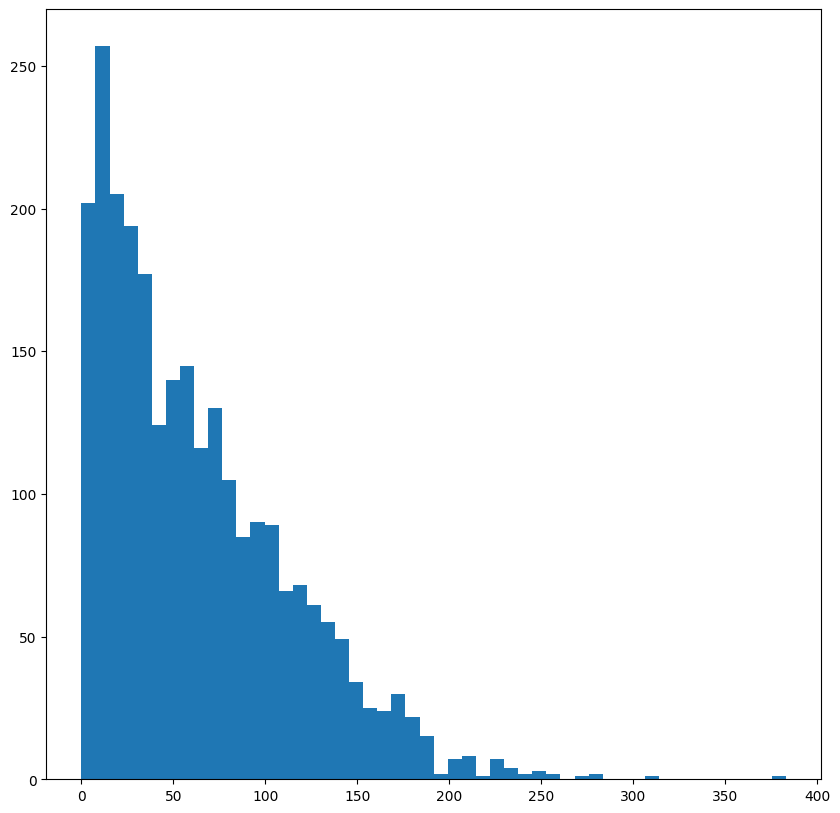

In [1370]:
_, _, pairwise_dist = initial_conditions_visible(ghz_visibles, mask=ghz_airs)
plt.hist(pairwise_dist.values(), bins=50)

In [1371]:
ghz_clusters = glom(initial_conditions_visible(ghz_visibles, mask=ghz_airs), 200)
cluster_cleanup(ghz_clusters, 6, randomly=True)

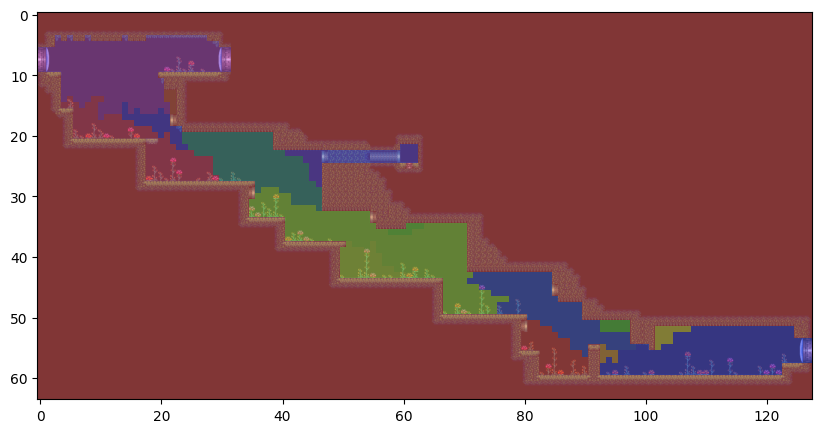

In [1376]:
#TODO mark space that doesn't need to be tested!
figsize(10,10)
# Why do we need these 0.5s? Thanks matplotlib
plt.imshow(graphics.image_from_state(level_state, rom_m), alpha=0.7, extent=(-0.5, ghz_array.shape[0] -0.5, ghz_array.shape[1] -0.5, -0.5))
#plt.imshow(mk_class_array(ghz_is_air, ghz_clusters, sort=sort_vis).T, alpha=0.5, cmap="gist_rainbow")
plt.imshow(mk_class_array(ghz_is_air, ghz_clusters, sort=sort_random).T, alpha=0.3, cmap="prism")
#plt.imshow(mk_class_array(op2, cs).T, alpha=0.5, cmap="flag")
#plt.imshow(mk_class_array(opp2, clusters).T, alpha=0.5, cmap="prism")
plt.show()

In [736]:
# Elbow criterion visualization
#TODO big triangle!
# Lower vertex of the biggest triangle is where we want to be

In [924]:
variances = []
for i in range(30):
    cs, ps = hierarchical_cluster(openness_r1, i)
    variances.append(np.std([c._mean for c in cs.values()]) ** 2)

In [925]:
total_variation = np.std([openness_1[c] for c in iter2d(openness_1)]) ** 2

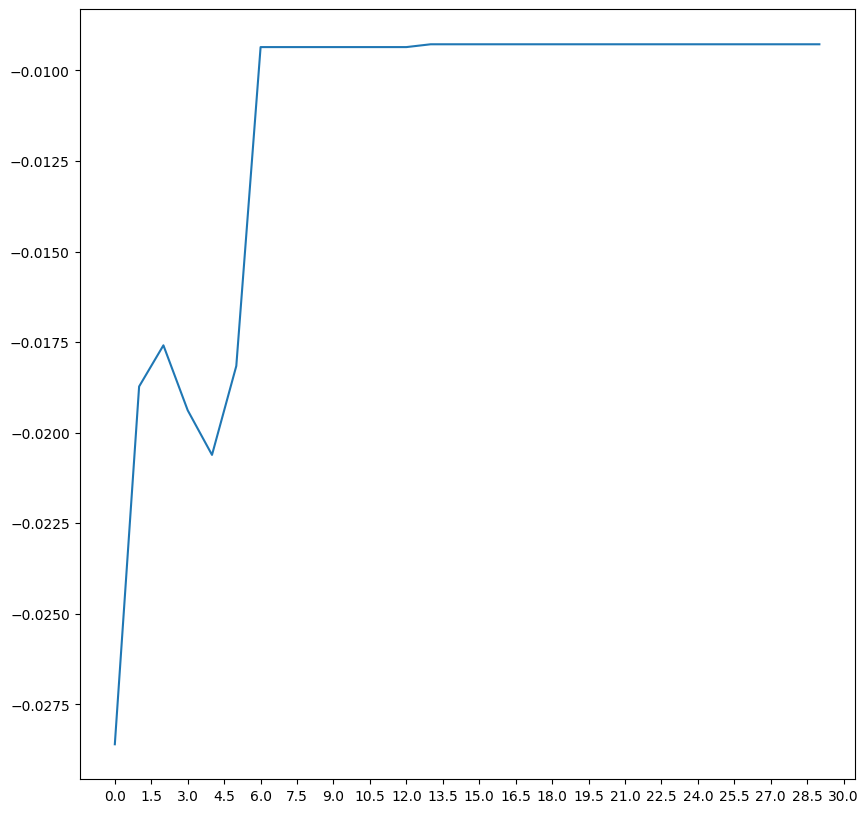

In [926]:
xs = range(30)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(30))
plot(xs, - np.array(variances) / total_variation)

In [927]:
#TODO: Look at the median openness value to do something...

In [928]:
opens = []
for c in iter2d(openness_r1):
    opens.append(openness_r1[c])

(array([ 68., 208., 371., 228.,  36.,   0.,   0.,   2.,  38.,  29.,  97.,
        179., 134.,  62.,  63.,  61.,  90.,  95., 141., 146.]),
 array([-7.39866667, -6.27353333, -5.1484    , -4.02326667, -2.89813333,
        -1.773     , -0.64786667,  0.47726667,  1.6024    ,  2.72753333,
         3.85266667,  4.9778    ,  6.10293333,  7.22806667,  8.3532    ,
         9.47833333, 10.60346667, 11.7286    , 12.85373333, 13.97886667,
        15.104     ]),
 <BarContainer object of 20 artists>)

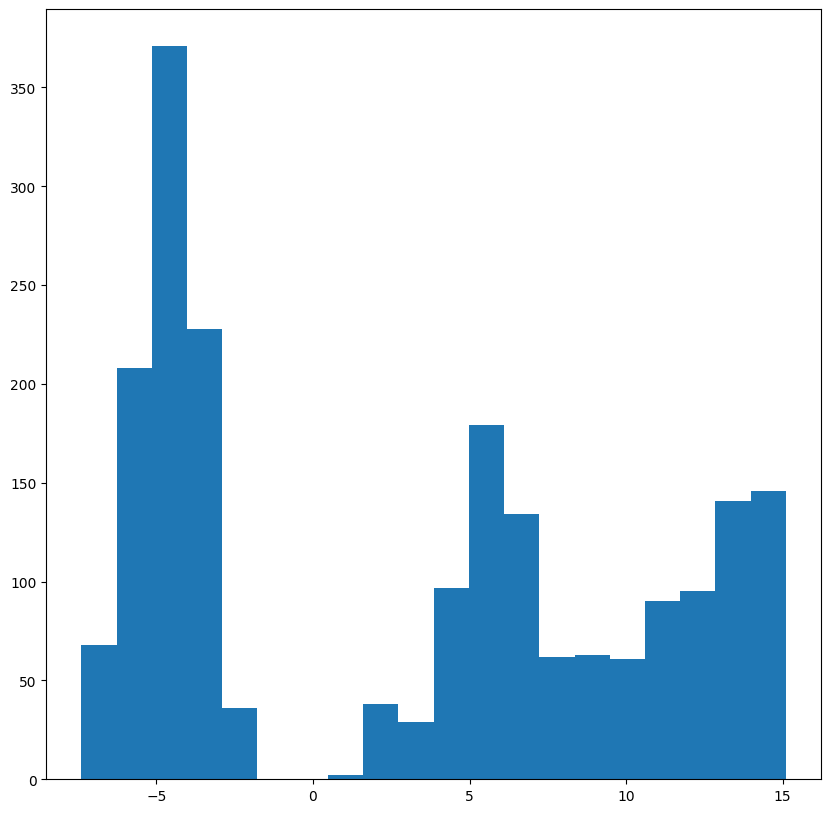

In [929]:
plt.hist(opens, bins=20)
#TODO: look at this distribution across multiple rooms

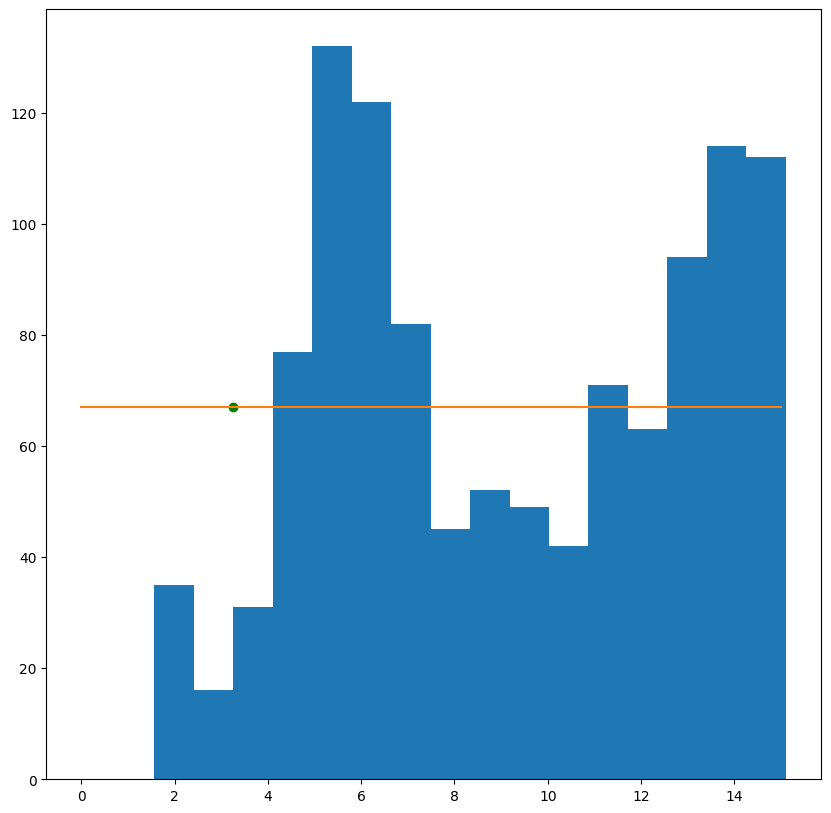

In [954]:
plus_opens = [o for o in opens if o >= 0]
max_open = int(max(plus_opens) + 1)
bins = plt.hist(plus_opens, bins=(max_open))
med = np.median(bins[0])
plt.plot(range(max_open), [med] * max_open)

plt.scatter([compute_cluster_param(openness_r1)],[med], color="green")

In [949]:
compute_cluster_param(openness_r1)

3.2549444444444444